### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score

### Setting Seeds

In [2]:
tf.random.set_seed(7)
np.random.seed(7)

### Daten generator

In [3]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                    rotation_range=10,
                                    zoom_range=0.2,
                                    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

### Daten laden

In [4]:
# training data
train_generator = train_datagen.flow_from_directory('./dataset split/train',
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(300, 300),
                                                    subset = 'training',
                                                    shuffle=True
                                                   )
# Validation data
validation_generator =  train_datagen.flow_from_directory('./dataset split/train',
                                                         batch_size=32,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300),
                                                         shuffle=False,
                                                         subset = 'validation'
                                                        )
# test data
test_generator =  test_datagen.flow_from_directory('./dataset split/test',
                                                 batch_size=16,
                                                 class_mode  = 'binary',
                                                 target_size = (300, 300),
                                                 shuffle = False
                                                 )

Found 865 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Found 271 images belonging to 2 classes.


In [5]:
train_generator.class_indices.keys()

dict_keys(['forest', 'living area'])

### Bilder ausgeben

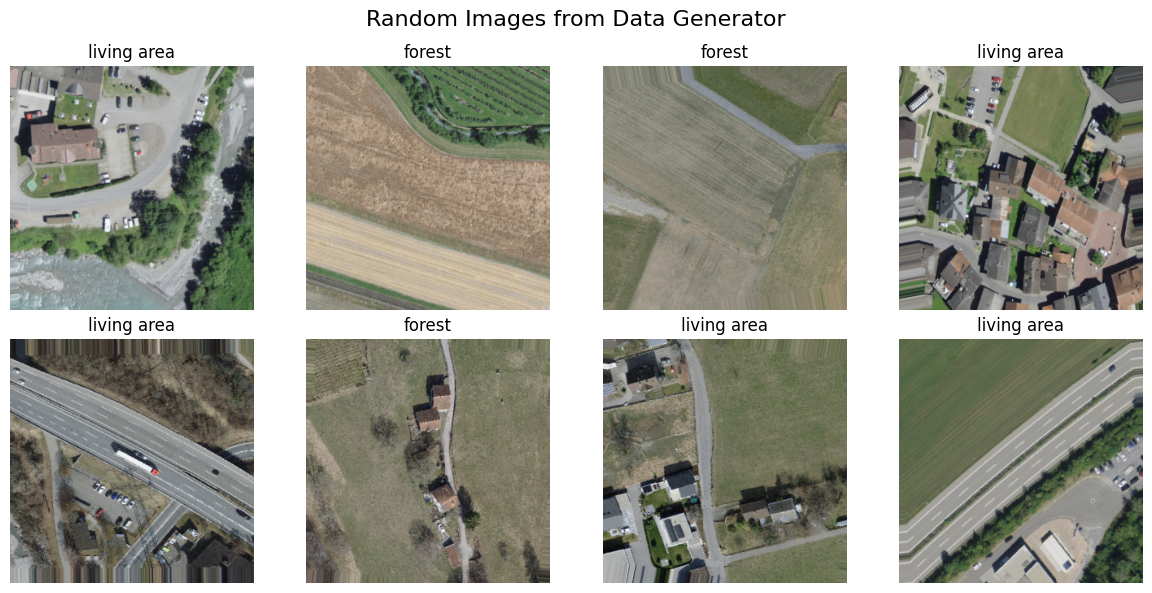

In [6]:
def plot_random_images_from_generator(generator, num_images=8):
    plt.figure(figsize=(12, 6))
    plt.suptitle('Random Images from Data Generator', fontsize=16)

    # einen Batch nehmen vom Daten Generator
    batch = next(generator)
    images, labels = batch

    # random indices auswählen (Bilder sind mit Zahlen beschrieben, nummeriert)
    indices = np.random.choice(len(images), num_images, replace=False)

    class_labels = list(generator.class_indices.keys())

    for i, index in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[index])
        if len(class_labels) == 2:  # hier erfolgt die binäre Klassifikation
            if labels[index] == 0:
                class_name = class_labels[0]
            else:
                class_name = class_labels[1]
        else:
            class_name = class_labels[np.argmax(labels[index])]
        plt.title(class_name)  # hier wird Klassenname ausgegeben anstatt Indices (anstatt Nummerierung, siehe oben)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_random_images_from_generator(train_generator)


### Klassen

In [7]:
train_generator.class_indices

{'forest': 0, 'living area': 1}

### Model Implementierung

### 1) ANN Model 

In [17]:
ann= models.Sequential()
ann.add(layers.Flatten(input_shape=(300, 300,3)))
ann.add(layers.Dense(128, 'relu'))
ann.add(layers.Dense(64, activation = 'relu'))
ann.add(layers.Dense(32, activation = 'relu'))
ann.add(layers.Dense(1 , activation= 'sigmoid'))

ann.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

checkpoint_filepath = 'ann_best_weights.h5' # best weights abspeichern

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 270000)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               34560128  
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,570,497
Trainable params: 34,570,497
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [18]:
ann_results = ann.fit(
            train_generator,
            epochs = 10,
            validation_data = validation_generator,
            callbacks=[checkpoint_callback])

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.2884 - accuracy: 0.5573
Epoch 1: val_accuracy improved from -inf to 0.65409, saving model to ann_best_weights.h5
20/20 [==============================] - 70s 3s/step - loss: 1.2884 - accuracy: 0.5573 - val_loss: 1.1919 - val_accuracy: 0.6541
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.8143 - accuracy: 0.5589
Epoch 2: val_accuracy did not improve from 0.65409
20/20 [==============================] - 78s 4s/step - loss: 0.8143 - accuracy: 0.5589 - val_loss: 0.6839 - val_accuracy: 0.6541
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.6138
Epoch 3: val_accuracy improved from 0.65409 to 0.74843, saving model to ann_best_weights.h5
20/20 [==============================] - 69s 3s/step - loss: 0.6821 - accuracy: 0.6138 - val_loss: 0.5739 - val_accuracy: 0.7484
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.6188 - accuracy: 0.6641
Epoch

### Visualisierung

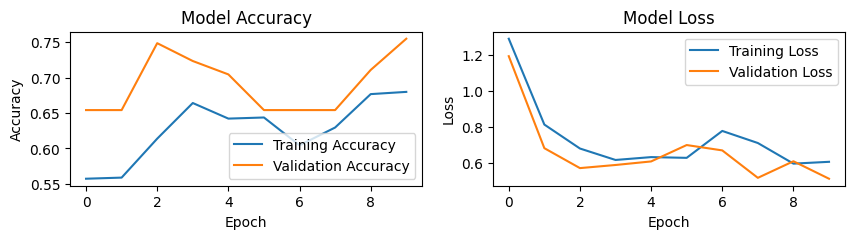

In [19]:
plt.figure(figsize=(10, 3))

# training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(ann_results.history['accuracy'], label='Training Accuracy')
plt.plot(ann_results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ann_results.history['loss'], label='Training Loss')
plt.plot(ann_results.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Voraussage auf Test-Set (Prediction)

In [20]:
ann.save('ann_best_model.h5')

In [21]:
# model laden
loaded_model = tf.keras.models.load_model('ann_best_model.h5')

loaded_model.load_weights('ann_best_weights.h5') # beste Gewichte

# Model auf Test-Set anwenden (Voraussage)
ann_prediction = loaded_model.predict(test_generator)
ann_predicted_labels = [1 if value > 0.5 else 0 for value in ann_prediction]
y_test_labels = test_generator.classes

17/17 [==============================] - 17s 984ms/step


### Metriken Evaluierung

In [22]:
# Accuracy
print(f'Accuracy on test set is : {accuracy_score(y_test_labels, ann_predicted_labels)}\n')

# Precision
print(f"Precision on test set is : {precision_score(y_test_labels, ann_predicted_labels)}\n")

# Recall
print(f"Recall on test set is : {recall_score(y_test_labels, ann_predicted_labels)}\n")

# F1 score
print(f"F1_score on test set is : {f1_score(y_test_labels, ann_predicted_labels)}\n")


Accuracy on test set is : 0.5571955719557196

Precision on test set is : 0.5240174672489083

Recall on test set is : 0.916030534351145

F1_score on test set is : 0.6666666666666666



### Clasification Report & Confusion Matrix

               ========Classification Report========

              precision    recall  f1-score   support

      forest       0.74      0.22      0.34       140
 living area       0.52      0.92      0.67       131

    accuracy                           0.56       271
   macro avg       0.63      0.57      0.50       271
weighted avg       0.63      0.56      0.50       271





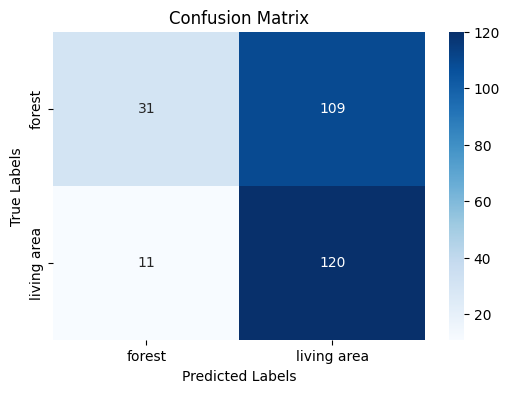

In [23]:
print('               ========Classification Report========\n')
classes = list(test_generator.class_indices.keys())
# Classification Report
print(classification_report(y_test_labels, ann_predicted_labels, target_names= classes))
print('\n')

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, ann_predicted_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels = classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 2) CNN Model

In [24]:
# Creating a Sequential model
cnn = tf.keras.Sequential()

# Layers zum Model hinzufügen + Activation function
cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(32, activation='relu'))

cnn.add(Dense(1, activation='sigmoid'))

# Model kompilieren
cnn.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

checkpoint_filepath = 'cnn_best_weights.h5' # best weights abspeichern

# Modelcheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 flatten_2 (Flatten)         (None, 1382976)           0         
                                                                 
 dense_8 (Dense)             (None, 64)                88510528  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                      

### Model Training

In [26]:
cnn_results = cnn.fit(
            train_generator,
            epochs = 10,
            validation_data = validation_generator,
            callbacks=[checkpoint_callback])

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.8791
Epoch 1: val_accuracy improved from 0.79874 to 0.81761, saving model to cnn_best_weights.h5
20/20 [==============================] - 107s 5s/step - loss: 0.3080 - accuracy: 0.8791 - val_loss: 0.4274 - val_accuracy: 0.8176
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8791
Epoch 2: val_accuracy did not improve from 0.81761
20/20 [==============================] - 104s 5s/step - loss: 0.3032 - accuracy: 0.8791 - val_loss: 0.4742 - val_accuracy: 0.7925
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8776
Epoch 3: val_accuracy did not improve from 0.81761
20/20 [==============================] - 105s 5s/step - loss: 0.3197 - accuracy: 0.8776 - val_loss: 0.6063 - val_accuracy: 0.7421
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.9089
Epoch 4: val_accuracy improved from 0.81

### Visualisierung

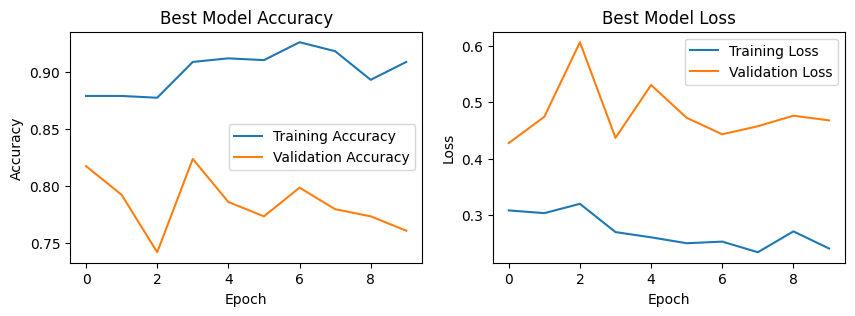

In [27]:
plt.figure(figsize=(10, 3))

# training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(cnn_results.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(cnn_results.history['loss'], label='Training Loss')
plt.plot(cnn_results.history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Voraussage auf Test-Set (Prediction)

In [28]:
cnn.save('cnn_best_model.h5')

In [29]:
# Model laden
loaded_model = tf.keras.models.load_model('cnn_best_model.h5')

loaded_model.load_weights('cnn_best_weights.h5') # beste Gewichte

# Model auf Test-Set anwenden (Voraussage)
cnn_prediction = loaded_model.predict(test_generator)
cnn_predicted_labels = [1 if value > 0.5 else 0 for value in cnn_prediction]
y_test_labels = test_generator.classes

17/17 [==============================] - 20s 1s/step


In [30]:
# Accuracy
print(f'Accuracy on test set is : {accuracy_score(y_test_labels, cnn_predicted_labels)}\n')

# Precision
print(f"Precision on test set is : {precision_score(y_test_labels, cnn_predicted_labels)}\n")

# Recall
print(f"Recall on test set is : {recall_score(y_test_labels, cnn_predicted_labels)}\n")

# F1 score
print(f"F1_score on test set is : {f1_score(y_test_labels, cnn_predicted_labels)}\n")


Accuracy on test set is : 0.7380073800738007

Precision on test set is : 0.65625

Recall on test set is : 0.9618320610687023

F1_score on test set is : 0.7801857585139319



### Confusion Matrix & Classification Report

               ========Classification Report========

              precision    recall  f1-score   support

      forest       0.94      0.53      0.68       140
 living area       0.66      0.96      0.78       131

    accuracy                           0.74       271
   macro avg       0.80      0.75      0.73       271
weighted avg       0.80      0.74      0.73       271





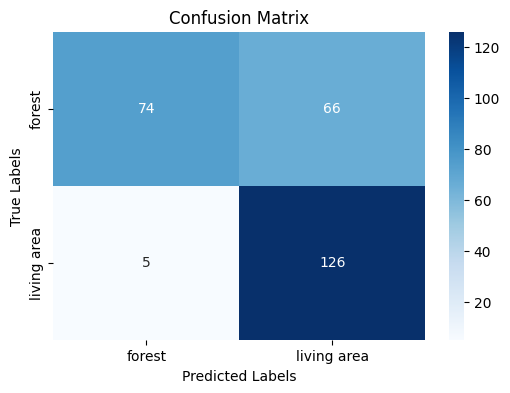

In [31]:
print('               ========Classification Report========\n')
classes = list(test_generator.class_indices.keys())
# Classification Report
print(classification_report(y_test_labels, cnn_predicted_labels, target_names= classes))
print('\n')

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, cnn_predicted_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels = classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 3) VGG16 Model

In [32]:
# training data
train_generator = train_datagen.flow_from_directory(train,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224, 224),
                                                    subset = 'training',
                                                    shuffle=True
                                                   )
# Validation data
validation_generator =  train_datagen.flow_from_directory(train,
                                                         batch_size=32,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224),
                                                         shuffle=False,
                                                         subset = 'validation'
                                                        )
# test data
test_generator =  test_datagen.flow_from_directory(test,
                                                 batch_size=32,
                                                 class_mode  = 'binary',
                                                 target_size = (224, 224),
                                                 shuffle = False
                                                 )

Found 637 images belonging to 2 classes.
Found 159 images belonging to 2 classes.
Found 271 images belonging to 2 classes.


In [33]:
from tensorflow.keras.applications import  VGG16

# VGG16 Model laden mit pre-trained Layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# vorherige Layer einfrieren des Basemodels
for layer in base_model.layers[:-10]: # alle Layer eingefroren
    layer.trainable = False

for layer in base_model.layers[-10:]: # ausser letzte 10 Layer einfrieren
    layer.trainable = True


# Neues Model aufsetzen auf die nicht eingefrorenen Layer
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Model kompilieren
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_filepath = 'model_best_weights.h5' # beste weights abspeichern

# ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

model.summary()

58889256/58889256 [==============================] - 7s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                

### Model Training

In [34]:
model_results = model.fit(
            train_generator,
            epochs = 10,
            validation_data = validation_generator,
            callbacks=[checkpoint_callback])

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.7896 
Epoch 1: val_accuracy improved from -inf to 0.84906, saving model to model_best_weights.h5
20/20 [==============================] - 373s 18s/step - loss: 0.4158 - accuracy: 0.7896 - val_loss: 0.3328 - val_accuracy: 0.8491
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.8870 
Epoch 2: val_accuracy did not improve from 0.84906
20/20 [==============================] - 347s 17s/step - loss: 0.3180 - accuracy: 0.8870 - val_loss: 0.3388 - val_accuracy: 0.8428
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8870 
Epoch 3: val_accuracy did not improve from 0.84906
20/20 [==============================] - 367s 18s/step - loss: 0.3008 - accuracy: 0.8870 - val_loss: 0.3430 - val_accuracy: 0.8302
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.9027 
Epoch 4: val_accuracy improved fro

### Visualisierung

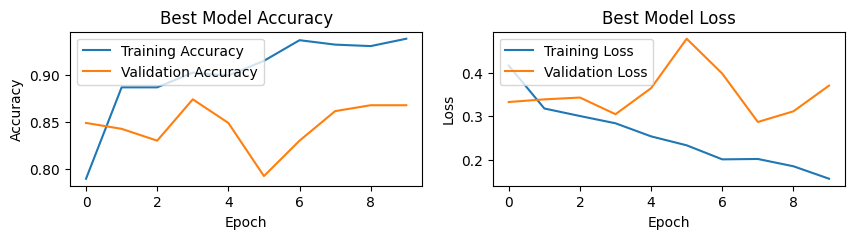

In [35]:
plt.figure(figsize=(10, 3))

# training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_results.history['accuracy'], label='Training Accuracy')
plt.plot(model_results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_results.history['loss'], label='Training Loss')
plt.plot(model_results.history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Voraussage auf Test-Set (Prediction)

In [36]:
model.save('model_best_model.h5')

In [37]:
# model laden
loaded_model = tf.keras.models.load_model('model_best_model.h5')

loaded_model.load_weights('model_best_weights.h5') # best weights

# Model auf Test-Set anwenden (Voraussage)
model_prediction = loaded_model.predict(test_generator)
model_predicted_labels = [1 if value > 0.5 else 0 for value in model_prediction]
y_test_labels = test_generator.classes

9/9 [==============================] - 76s 8s/step


In [38]:
# Accuracy
print(f'Accuracy on test set is : {accuracy_score(y_test_labels, model_predicted_labels)}\n')

# Precision
print(f"Precision on test set is : {precision_score(y_test_labels, model_predicted_labels)}\n")

# Recall
print(f"Recall on test set is : {recall_score(y_test_labels, model_predicted_labels)}\n")

# F1 score
print(f"F1_score on test set is : {f1_score(y_test_labels, model_predicted_labels)}\n")


Accuracy on test set is : 0.9040590405904059

Precision on test set is : 0.8571428571428571

Recall on test set is : 0.9618320610687023

F1_score on test set is : 0.9064748201438849



### Confusion Matrix & Classification Report

               ========Classification Report========

              precision    recall  f1-score   support

      forest       0.96      0.85      0.90       140
 living area       0.86      0.96      0.91       131

    accuracy                           0.90       271
   macro avg       0.91      0.91      0.90       271
weighted avg       0.91      0.90      0.90       271





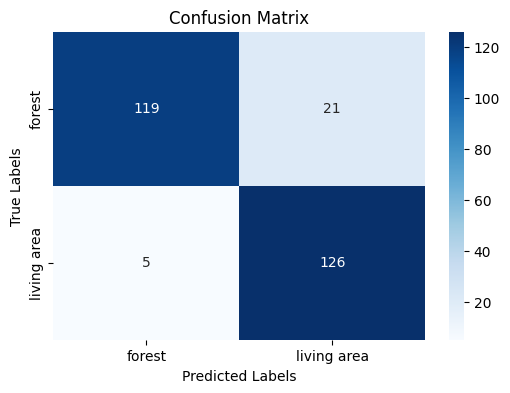

In [39]:
print('               ========Classification Report========\n')
classes = list(test_generator.class_indices.keys())
# Classification Report
print(classification_report(y_test_labels, model_predicted_labels, target_names= classes))
print('\n')

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, model_predicted_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels = classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()